# Imports and Functions

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import importlib
import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_confusion_matrix
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

Using TensorFlow backend.


In [2]:
import functions as fun

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Functions

In [4]:
def format_titles(title_list):
    """This function formats the movie titles in such a way that they can be
    discerned by the web site where the screenplays will be taken from.
    
    Parameter:
    
        title_list: list
        list of titles to be formatted, generally from metacritic.
        
    Returns: 
    
        list containing titles in the proper format for scraping screenplays from
        springfieldspringfield.co.uk."""
    
    # Initializing list for later
    titles_formatted = []
    
    # Will cycle through all titles and leave them in the correct format for
    # later use.
    for title in title_list:
        title = title.lower()
        
        # Titles on this site have ', the' at the end.
        if title[:3] == 'the':
            title = title[4:] + ', the'
        
        # Getting rid of punctuation that wouldn't be in the url.
        punctuations = """!()-[]{};:'"\,<>./?@#$%^&*~"""
        for x in title: 
            if x in punctuations: 
                title = title.replace(x, '')
        
        # In the url, the spaces are hyphens.
        for x in title:
            title = title.replace('  ', '-')
            title = title.replace(' ', '-')
            title = title.replace('_', '-')
            
        titles_formatted.append(title)

    return titles_formatted

In [5]:
def clean(word_list):
    """Combines each script into one long string and removes punctuation and
    html tags from the scripts. Note that this function is not always used,
    depending on what is needed from the data.
    
    Parameters:
    
        word_list: list
            List of words from one screenplay, usually in raw format
            
    Returns:
    
        A complete screenplay made of one long string with symbols and html
        breaks removed."""
    
    result = ''
    
    # Each line of the scipt is broken into a separate string. This combines
    # them into one long string.
    for line in word_list:
        result += str(line)
        
    # This removes the line breaks. They should have already been removed 
    # above but this is a backup.
    while '<br/>' in result:
        result = result.replace('<br/>', '')
        
    # Removing punctuations.
    punctuations = """!()-[]{};:"\,<>./?@#$%^&*_~"""
    for char in result: 
        if char in punctuations: 
            result = result.replace(char, '')
    
    return result

In [6]:
def script_classifiers(X, y, classifier, cmap=plt.cm.Reds, use_tfidf=True):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model."""
    
    # Typical train test split to retain data for validation.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
    
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Provides the option of using tfidf in case this is just using scripts 
    # attributes and not text embedding or vectorization
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        
        # These tfidf hyper-parameters have been tested via grid-search
        # elsewhere and found to be optimal.
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
        
#     scaler = StandardScaler
#     X_resampled_scaled = scaler.fit_transform(X_resampled)
#     X_test_scaled = scaler.transform(X_test)
    
    # Fitting the pipeline containing the tfidf processor and classifier.
    pipe.fit(X_resampled, y_resampled)
    
    # Creating predicted data.
    y_pred = pipe.predict(X_test)
    
    # Running metrics and creating a confusion matrix visual.
    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = pipe.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 

In [7]:
def hybrid_classifiers(X_train, X_test, y_train, y_test, classifier, 
                       cmap=plt.cm.Reds, use_tfidf=True):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model."""
    
    # Typical train test split to retain data for validation.
#     X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=.3,
#                                                     random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
    
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Provides the option of using tfidf in case this is just using scripts 
    # attributes and not text embedding or vectorization
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        
        # These tfidf hyper-parameters have been tested via grid-search
        # elsewhere and found to be optimal.
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
        
#     scaler = StandardScaler
#     X_resampled_scaled = scaler.fit_transform(X_resampled)
#     X_test_scaled = scaler.transform(X_test)
    
    # Fitting the pipeline containing the tfidf processor and classifier.
    pipe.fit(X_resampled, y_resampled)
    
    # Creating predicted data.
    y_pred = pipe.predict(X_test)
    
    # Running metrics and creating a confusion matrix visual.
    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = pipe.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 

In [8]:
def ceci_nest_pas_une_pipe(X, y, text_to_vec, classifier, 
                           cmap=plt.cm.Reds):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot. As opposed with 
    the above 'script_classifiers' function, this one does not use a pipe,
    lending some additional flexibility between vectorization and modeling.
    Generally to be used with combining features and word vectors.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        text_to_vec: word vector matrix
            In addition to features, adds a word vector matrix to join with
            the other features for modeling.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot."""

#     if text_to_vec:
    # Putting the TfidfVectorizer up front so I can fiddle with things
    # before the classifier.
    tfidf = TfidfVectorizer(max_df=.95, min_df=.1, max_features=5000,
                             ngram_range=(1,2))
    X2 = tfidf.fit_transform(text_to_vec)

    # Creating a sparse DataFrame to house both the features and the 
    # processed text.
    X_temp = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                               default_fill_value=0)

    # Necessary for next step.
    X = X.reset_index(drop=True)

    # Combining text matrix with script attributes.
    for column in X:
        X_temp[column] = X[column]
    X = X_temp
    
    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
   
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actually wants a series if its only one column.
    if type(X_resampled) == pd.core.series.Series:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Classifier can be whatever the user has entered as an argument. 
    clf = classifier
    clf.fit(X_resampled, y_resampled)
    
#     # The below is for creating the train scores.
#     y_train_pred = clf.predict(X_train)
    
#     # Printing out metrics and confusion matrix visual for training.
#     print(classification_report(y_train, y_train_pred))
#     print('Accuracy: ', accuracy_score(y_train, y_train_pred))

#     confusion = confusion_matrix(y_train, y_train_pred)
#     plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
#                   show_normed=True, cmap=cmap);
#     plt.show();
    
    # The below is for creating the test scores.
    y_pred = clf.predict(X_test)
    
    # Printing out metrics and confusion matrix visual for testing.
    print(classification_report(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = classifier.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
    if feature_importance:  
        try:
            print(pd.Series(clf.feature_importances_,
                      index=X_train.columns).sort_values(ascending=False).head(200))
            df_importance = pd.Series(clf.feature_importances_, 
                                      index=X_train.columns)
            df_imp_export = df_importance.sort_values(ascending=False)
            df_importance = df_importance.sort_values(ascending=True).tail(200)
        #         df_importance.index = [labels[x] for x,y in df_importance]
            df_importance.plot(kind='barh', figsize=(8,50))
            plt.title('Most Important Features')
            plt.ylabel('Feature Name')
            plt.xlabel('Feature Importance')
            plt.show()
        except: 
            pass
    
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 

In [9]:
def grid_search_a(X, y, classifier, param_grid, use_tfidf=True):
    """Performs a grid search to optimize parameters for classification models.
    
    Parameters:
    
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model.
            
        Returns:
            dictionary of best parameters."""

    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # Under-sampling to even out the field.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

    # If only one column, the classifier wants it as a series.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # User has a choice to use a tfidf classifier or not.
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
    
    # Performs a grid search and generates the best parameter set.
    grid_search = GridSearchCV(pipe, cv=None,
                               return_train_score=True, verbose=10,
                               scoring='accuracy', param_grid=param_grid,
                               n_jobs=-1)

    grid_search.fit(X_resampled, y_resampled)

    # Create mean training and test scores.
    training_score = np.mean(grid_search.cv_results_['mean_train_score'])
    testing_score = grid_search.score(X_test, y_test)

    # Spit out the results.
    print(f"Mean Training Score: {training_score :.2%}")
    print(f"Mean Test Score: {testing_score :.2%}")
    print("Best Parameter Combination Found During Grid Search:")
    print(grid_search.best_params_)

    # Return the parameters so they can be seen and contemplated.
    return grid_search.best_params_

In [324]:
def hybrid_classifier_combo(X_train, X_test, X2_train, X2_test,
                            y_train, y_test, classifier,
                            cmap=plt.cm.Reds, feature_importance=False):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot. As opposed with 
    the above 'script_classifiers' function, this one does not use a pipe,
    lending some additional flexibility between vectorization and modeling.
    Generally to be used with combining features and word vectors.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        text_to_vec: word vector matrix
            In addition to features, adds a word vector matrix to join with
            the other features for modeling.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot."""

#     if text_to_vec:
    # Putting the TfidfVectorizer up front so I can fiddle with things
    # before the classifier.
    tfidf = TfidfVectorizer(max_df=.95, min_df=.1, max_features=5000,
                             ngram_range=(1,2))
    X2_train = tfidf.fit_transform(X2_train)
    X2_test = tfidf.transform(X2_test)    

    # Creating a sparse DataFrame to house both the features and the 
    # processed text.
    X_temp = pd.SparseDataFrame(X2_train, columns=tfidf.get_feature_names(),
                               default_fill_value=0)
                                                        
    X_temp2 = pd.SparseDataFrame(X2_test, columns=tfidf.get_feature_names(),
                               default_fill_value=0)
    
    # Necessary for next step.
#     X_train = X_train.reset_index(drop=True)
#     X_test = X_test.reset_index(drop=True)
    
    # Combining text matrix with script attributes.
    for column in X_train:
        X_temp[column] = X_train[column]
        X_temp2[column] = X_test[column]
    X_train = X_temp
    X_test = X_temp2
    
#     temp = pd.DataFrame(X2_train, columns=['temp'])
#     display(X_train.iloc[[40, 69, 101, 106, 147, 175, 264, 303, 343, 371, 392,
#              464, 656, 811, 963, 1099, 2024, 2044, 2066, 2265, 2554,2560]])
    
    X_train.fillna(0,inplace=True)
    # Standard train-test split.
#     X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=.3,
#                                                     random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
   
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
#     if type(X_resampled) == pd.core.series.Series:
#         X_resampled = X_resampled.iloc[:, 0]
    
    # Classifier can be whatever the user has entered as an argument. 
    clf = classifier
    clf.fit(X_resampled, y_resampled)
    
#     # The below is for creating the train scores.
#     y_train_pred = clf.predict(X_train)
    
#     # Printing out metrics and confusion matrix visual for training.
#     print(classification_report(y_train, y_train_pred))
#     print('Accuracy: ', accuracy_score(y_train, y_train_pred))

#     confusion = confusion_matrix(y_train, y_train_pred)
#     plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
#                   show_normed=True, cmap=cmap);
#     plt.show();

#     temp = pd.DataFrame(X_test, columns=['temp'])
#     print(temp[temp['temp'].isna() == True].index)

    temp = X_test.CCONJ.isna() == True
    display(temp)
    
    # The below is for creating the test scores.
    y_pred = clf.predict(X_test)
    
    # Printing out metrics and confusion matrix visual for testing.
    print(classification_report(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = classifier.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
    if feature_importance:  
        try:
            print(pd.Series(clf.feature_importances_,
                      index=X_train.columns).sort_values(ascending=False).head(200))
            df_importance = pd.Series(clf.feature_importances_, 
                                      index=X_train.columns)
            df_imp_export = df_importance.sort_values(ascending=False)
            df_importance = df_importance.sort_values(ascending=True).tail(200)
        #         df_importance.index = [labels[x] for x,y in df_importance]
            df_importance.plot(kind='barh', figsize=(8,50))
            plt.title('Most Important Features')
            plt.ylabel('Feature Name')
            plt.xlabel('Feature Importance')
            plt.show()
        except: 
            pass

# Modeling

## Bring in the data

In [11]:
rotten_df_cut = pd.read_csv('rotten_df_cut.csv', index_col=0)
screenplays_cut = pd.read_csv('screenplays_cut.csv', index_col=0)
# Cutting off the old index columns added during import
# rotten_df_cut.drop(rotten_df_cut.columns[:2], axis=1, inplace=True)

In [12]:
len(rotten_df_cut.columns)

90

In [13]:
screenplays_cut.head(1)

,titles,scripts,good_or_bad,all_together_now,no_stop,just_words,word_count,unique_words,temp,sentiment_scores,sentiment_negative,sentiment_neutral,sentiment_positive,sentiment_compound,colon_ratios,semi_ratios,comma_ratios,ellipsis_ratios,sentence_length,category,Category Label,nlp,POS_counts,TAG_counts,PROPN,PUNCT,SYM,VERB,X,SPACE,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,UH,NNP,VBZ,MD,DT,IN,.,CC,VBN,NN,JJ,PRP,RB,VB,VBD,_SP,NNS,HYPH,``,XX,FW,WP,VBG,RBS,-LRB-,NFP,:,VBP,-RRB-,ADD,'',AFX,TO,",",EX,JJR,PRP$,POS,LS,WRB,RP,CD,NNPS,PDT,RBR,WDT,JJS,WP$,$
0,101-dalmatians,['\n\n [ Clock Chiming ...,1,\n\n [ Clock Chiming ] ...,[ clock chiming ] [ alarm ] [ groaning ] [ wh...,clock chiming alarm groaning whimpering barki...,8401,6219,<class 'str'>,"{'neg': 0.129, 'neu': 0.643, 'pos': 0.227, 'co...",0.129,0.643,0.227,0.9999,0.000482,0.000322,0.076379,0.015597,5.270339,2,Dark Movies and Documentaries,\n\n [ Clock Chiming ] ...,"{103: 63, 97: 3668, 96: 781, 100: 1512, 92: 12...","{6893682062797376370: 63, 17111077179131903759...",0.092965,0.436615,0.0,0.179979,0.001666,0.007499,0.043923,0.044995,0.06404,0.005237,0.012499,0.069397,0.035234,0.150815,0.006904,0.018331,0.07392,0.035234,0.089751,0.022854,0.013927,0.053803,0.044995,0.127485,0.012499,0.013451,0.120105,0.0419,0.067492,0.056422,0.054279,0.013927,0.007499,0.030711,0.027259,0.000476,0.001666,0.0,0.006428,0.032853,0.000238,0.082014,0.005357,0.051065,0.033925,0.082014,0.0,0.003809,0.0,0.009404,0.057136,0.000714,0.001428,0.013094,0.002143,0.0,0.005833,0.006785,0.006904,0.003214,0.000833,0.000833,0.001666,0.000595,0.0,0.0


In [14]:
rotten_df_cut.head(1)

,Titles,TitlesFormatted,RottenScores,Scripts,AllTogetherNow,NoStop,JustWords,word_count,unique_words,sentiment_scores,sentiment_negative,sentiment_neutral,sentiment_positive,sentiment_compound,colon_ratios,semi_ratios,comma_ratios,ellipsis_ratios,sentence_length,category,CategoryLabel,nlp,POS_counts,TAG_counts,PROPN,PUNCT,SYM,VERB,X,SPACE,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,HYPH,``,XX,FW,WP,VBG,UH,RBS,-LRB-,NNP,VBZ,MD,NFP,:,VBP,-RRB-,ADD,DT,'',IN,AFX,.,TO,CC,VBN,NN,",",EX,JJR,PRP$,POS,LS,WRB,JJ,RP,CD,PRP,RB,NNPS,VB,PDT,RBR,WDT,JJS,VBD,_SP,WP$,NNS,$
0,the_gallows_act_ii,gallows-act-ii-the,0,"['\n\n 1', ' - Do it.',...","['\n\n 1', ' - Do it.',...","['\n\n 1', ' - it.', ' - right.', ' oh, gosh....",nn 1 right oh gosh oh gosh bro charlie mexica...,6246,4372,"{'neg': 0.1, 'neu': 0.749, 'pos': 0.151, 'comp...",0.1,0.749,0.151,0.9995,0.000457,0.0,0.421089,0.019671,10.409524,1,Action & Science Fiction,"['\n\n 1', ' - Do it.',...","{97: 5781, 93: 40, 103: 2, 100: 1208, 95: 820,...","{17111077179131903759: 1, 4969857429396651903:...",0.044989,0.925552,0.0,0.193404,0.00032,0.00032,0.044348,0.04707,0.066923,0.006244,0.013609,0.073967,0.053474,0.096382,0.006404,0.021934,0.131284,0.001921,0.049472,0.00032,0.0,0.011848,0.01617,0.053474,0.0,0.00016,0.043868,0.028818,0.014569,0.004483,0.038264,0.041627,0.00032,0.0,0.056196,0.384886,0.04707,0.0,0.151297,0.012008,0.013609,0.008325,0.082293,0.294749,0.001121,0.002241,0.01505,0.003042,0.0,0.004323,0.041627,0.006884,0.006404,0.119436,0.061319,0.001121,0.06228,0.00064,0.00016,0.002081,0.00048,0.027858,0.00032,0.0,0.014089,0.0


In [15]:
# Adding column showing if a title is above or below a score of 50.
rotten_df_cut['good_or_bad'] = rotten_df_cut.RottenScores.apply(
    lambda x: 1 if x >=50 else 0)

In [16]:
screen_cols = list(screenplays_cut.columns)
screen_cols.remove('good_or_bad')
screen_cols.append('good_or_bad')
screenplays_model = screenplays_cut[screen_cols].copy()

rotten_cols = list(rotten_df_cut.columns)
rotten_cols.remove('RottenScores')
rotten_cols.append('RottenScores')
rotten_model = rotten_df_cut[rotten_cols].copy()
rotten_model.drop('Titles', axis=1, inplace=True)

In [17]:
sort_cols = list(rotten_model.columns[:38])
sort_cols.extend(sorted(list(rotten_model.columns[38:-2])))
sort_cols.extend(list(rotten_model.columns[-2:]))

In [18]:
rotten_model = rotten_model[sort_cols]

In [19]:
screenplays_cut.head()

,titles,scripts,good_or_bad,all_together_now,no_stop,just_words,word_count,unique_words,temp,sentiment_scores,sentiment_negative,sentiment_neutral,sentiment_positive,sentiment_compound,colon_ratios,semi_ratios,comma_ratios,ellipsis_ratios,sentence_length,category,Category Label,nlp,POS_counts,TAG_counts,PROPN,PUNCT,SYM,VERB,X,SPACE,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,UH,NNP,VBZ,MD,DT,IN,.,CC,VBN,NN,JJ,PRP,RB,VB,VBD,_SP,NNS,HYPH,``,XX,FW,WP,VBG,RBS,-LRB-,NFP,:,VBP,-RRB-,ADD,'',AFX,TO,",",EX,JJR,PRP$,POS,LS,WRB,RP,CD,NNPS,PDT,RBR,WDT,JJS,WP$,$
0,101-dalmatians,['\n\n [ Clock Chiming ...,1,\n\n [ Clock Chiming ] ...,[ clock chiming ] [ alarm ] [ groaning ] [ wh...,clock chiming alarm groaning whimpering barki...,8401,6219,<class 'str'>,"{'neg': 0.129, 'neu': 0.643, 'pos': 0.227, 'co...",0.129,0.643,0.227,0.9999,0.000482,0.000322,0.076379,0.015597,5.270339,2,Dark Movies and Documentaries,\n\n [ Clock Chiming ] ...,"{103: 63, 97: 3668, 96: 781, 100: 1512, 92: 12...","{6893682062797376370: 63, 17111077179131903759...",0.092965,0.436615,0.000000,0.179979,0.001666,0.007499,0.043923,0.044995,0.064040,0.005237,0.012499,0.069397,0.035234,0.150815,0.006904,0.018331,0.073920,0.035234,0.089751,0.022854,0.013927,0.053803,0.044995,0.127485,0.012499,0.013451,0.120105,0.041900,0.067492,0.056422,0.054279,0.013927,0.007499,0.030711,0.027259,0.000476,0.001666,0.0,0.006428,0.032853,0.000238,0.082014,0.005357,0.051065,0.033925,0.082014,0.0,0.003809,0.0,0.009404,0.057136,0.000714,0.001428,0.013094,0.002143,0.0,0.005833,0.006785,0.006904,0.003214,0.000833,0.000833,0.001666,0.000595,0.000000,0.000000
1,12-angry-men,['\n\n You did a wonder...,1,\n\n You did a wonderfu...,"wonderful job. wonderful. it. it! continue, y...",wonderful job wonderful continue youve listen...,13144,6953,<class 'str'>,"{'neg': 0.168, 'neu': 0.683, 'pos': 0.149, 'co...",0.168,0.683,0.149,-0.9997,0.002445,0.000000,0.083273,0.017259,3.542028,1,Action & Science Fiction,\n\n You did a wonderfu...,"{103: 2, 95: 2116, 100: 3407, 90: 1654, 84: 72...","{6893682062797376370: 2, 13656873538139661788:...",0.007912,0.247337,0.000456,0.259206,0.000000,0.000152,0.055463,0.079808,0.096318,0.008521,0.014836,0.125837,0.017194,0.154976,0.018868,0.030508,0.160986,0.017194,0.007912,0.038497,0.020161,0.106817,0.079808,0.147292,0.014836,0.017194,0.127739,0.053408,0.147139,0.082775,0.078591,0.044431,0.000152,0.027237,0.003271,0.001674,0.000000,0.0,0.013847,0.015140,0.000304,0.000000,0.002130,0.042605,0.053713,0.000000,0.0,0.006315,0.0,0.017651,0.044051,0.003043,0.001065,0.014912,0.002739,0.0,0.009814,0.010119,0.018868,0.000000,0.002206,0.000380,0.001826,0.000989,0.000076,0.000152
2,12-years-a-slave,"['\n\n All right now.',...",1,\n\n All right now. Y'a...,right now. y'all fresh niggers. y'all gonna c...,right yall fresh niggers yall gonna cutting g...,8092,4291,<class 'str'>,"{'neg': 0.163, 'neu': 0.632, 'pos': 0.204, 'co...",0.163,0.632,0.204,0.9992,0.000233,0.000000,0.127709,0.030529,3.116195,0,Classical & British,\n\n All right now. Y'a...,"{103: 2, 86: 618, 97: 2099, 84: 397, 92: 1255,...","{6893682062797376370: 2, 164681854541413346: 5...",0.079461,0.259392,0.000000,0.237024,0.000000,0.000247,0.049061,0.090213,0.076372,0.006179,0.023604,0.114310,0.017672,0.155091,0.008156,0.029906,0.144834,0.017672,0.078596,0.029412,0.022986,0.079338,0.090213,0.164113,0.023604,0.014459,0.126174,0.044983,0.136060,0.062531,0.088482,0.023480,0.000247,0.028917,0.002348,0.001483,0.000000,0.0,0.008774,0.011122,0.000741,0.000000,0.005067,0.014706,0.053262,0.000000,0.0,0.003955,0.0,0.014088,0.067721,0.002348,0.003089,0.031142,0.004696,0.0,0.009145,0.011122,0.008156,0.000865,0.001359,0.001607,0.002348,0.000989,0.000124,0.000000
3,127-hours,"['\n\n Hey. Aron here, ...",1,"\n\n Hey. Aron here, le...","hey. aron here, leave message. hi aron, sonja...",hey aron leave message hi aron sonja hereagai...,2191,1233,<class 'str'>,"{'neg': 0.15, 'neu': 0.586, 'pos': 0.264, 'com...",0.150,0.586,0.264,0.9996,0.004866,0.0

In [20]:
rotten_model.head()

,TitlesFormatted,Scripts,AllTogetherNow,NoStop,JustWords,word_count,unique_words,sentiment_scores,sentiment_negative,sentiment_neutral,sentiment_positive,sentiment_compound,colon_ratios,semi_ratios,comma_ratios,ellipsis_ratios,sentence_length,category,CategoryLabel,nlp,POS_counts,TAG_counts,PROPN,PUNCT,SYM,VERB,X,SPACE,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,$,'',",",-LRB-,-RRB-,.,:,ADD,AFX,CC,CD,DT,EX,FW,HYPH,IN,JJ,JJR,JJS,LS,MD,NFP,NN,NNP,NNPS,NNS,PDT,POS,PRON,PRP,PRP$,RB,RBR,RBS,RP,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,XX,_SP,``,good_or_bad,RottenScores
0,gallows-act-ii-the,"['\n\n 1', ' - Do it.',...","['\n\n 1', ' - Do it.',...","['\n\n 1', ' - it.', ' - right.', ' oh, gosh....",nn 1 right oh gosh oh gosh bro charlie mexica...,6246,4372,"{'neg': 0.1, 'neu': 0.749, 'pos': 0.151, 'comp...",0.100,0.749,0.151,0.9995,0.000457,0.0,0.421089,0.019671,10.409524,1,Action & Science Fiction,"['\n\n 1', ' - Do it.',...","{97: 5781, 93: 40, 103: 2, 100: 1208, 95: 820,...","{17111077179131903759: 1, 4969857429396651903:...",0.044989,0.925552,0.000000,0.193404,0.000320,0.000320,0.044348,0.047070,0.066923,0.006244,0.013609,0.073967,0.053474,0.096382,0.006404,0.021934,0.000000,0.384886,0.294749,0.000160,0.000320,0.151297,0.038264,0.0,0.0,0.013609,0.006404,0.056196,0.001121,0.000000,0.001921,0.047070,0.041627,0.002241,0.000480,0.000000,0.014569,0.004483,0.082293,0.043868,0.001121,0.014089,0.000640,0.003042,0.131284,0.119436,0.015050,0.061319,0.000160,0.000000,0.006884,0.012008,0.053474,0.062280,0.027858,0.016170,0.008325,0.041627,0.028818,0.002081,0.011848,0.000000,0.004323,0.000320,0.000320,0.049472,0,0
1,portals,"['\n\n 1', ' [boulderli...","['\n\n 1', ' [boulderli...","['\n\n 1', ' [boulderlight pictures theme]', ...",nn 1 boulderlight pictures theme bloody disgu...,6690,4734,"{'neg': 0.099, 'neu': 0.801, 'pos': 0.1, 'comp...",0.099,0.801,0.100,-0.9688,0.016688,0.0,0.400507,0.016054,13.186630,6,More Dark Movies,"['\n\n 1', ' [boulderli...","{97: 6554, 93: 50, 103: 2, 92: 724, 84: 270, 1...","{17111077179131903759: 185, 496985742939665190...",0.052317,0.979671,0.002840,0.214200,0.000299,0.000299,0.040359,0.044395,0.070852,0.007175,0.014948,0.068610,0.039761,0.108221,0.007474,0.027504,0.000149,0.384903,0.283259,0.027653,0.027205,0.156353,0.018685,0.0,0.0,0.014948,0.007474,0.053064,0.001943,0.000149,0.000897,0.044395,0.038714,0.001046,0.000598,0.000149,0.015546,0.005232,0.090732,0.052317,0.000000,0.017489,0.000598,0.003587,0.128849,0.115396,0.014200,0.061136,0.000897,0.000299,0.007474,0.016442,0.039761,0.068909,0.021824,0.025561,0.008072,0.051121,0.030344,0.000747,0.013453,0.000000,0.006577,0.000149,0.000299,0.075336,0,0
2,mob-town,"['\n\n 1', ' Police rai...","['\n\n 1', ' Police rai...","['\n\n 1', ' police raid organized crime meet...",nn 1 police raid organized crime meeting home...,11256,7649,"{'neg': 0.057, 'neu': 0.787, 'pos': 0.156, 'co...",0.057,0.787,0.156,0.9999,0.000915,0.0,0.403190,0.005229,7.885567,2,Dark Movies and Documentaries,"['\n\n 1', ' Police rai...","{97: 9595, 93: 117, 103: 2, 92: 1262, 90: 897,...","{17111077179131903759: 1, 4969857429396651903:...",0.054282,0.852434,0.000800,0.195096,0.000178,0.000178,0.042022,0.052861,0.082889,0.006397,0.010394,0.079691,0.047353,0.112118,0.010394,0.030650,0.000355,0.336976,0.273810,0.000089,0.000089,0.164268,0.001866,0.0,0.0,0.010394,0.010394,0.065299,0.001777,0.000000,0.002132,0.052861,0.039979,0.000977,0.001066,0.000000,0.012438,0.001421,0.090441,0.054016,0.000267,0.021677,0.001866,0.003554,0.135572,0.121713,0.011194,0.071162,0.000444,0.000178,0.011905,0.015192,0.047353,0.065299,0.018923,0.011105,0.009328,0.053483,0.030917,0.001155,0.013859,0.000178,0.009328,0.000178,0.000178,0.071784,0,0
3,solis,"['\n\n 1', ' [EERIE]', ...","['\n\n 1', ' [EERIE]', ...","['\n\n 1', ' [eerie]', ' woman: come in, 2024...",nn 1 eerie woman come 2024 hathor 18 confirmi...,7357,5111,"{'neg': 0.087, 'neu': 0.803, 'pos': 0.109, 'co...",0.087,0.803,0.109,0.9953,0.018979,0.0,0.384661,0.008609,

In [21]:
len(rotten_model.columns)

90

In [22]:
len(screenplays_model.columns)

90

Was going to use the below to ensure consistency between DataFrames.

In [23]:
# drop_from_rt = [col for col in rotten_df_cut.columns\
#                 if col not in screenplays_cut.columns]

In [24]:
# drop_from_screen = [col for col in screenplays_cut.columns\
#                     if col not in rotten_df_cut.columns]

In [25]:
# Temporary thing, might not need in the future once old jobs run.
# screenplays_model.drop('temp', axis=1, inplace=True)

More stuff that is now unnecessary, keeping for a little bit just in case.

In [26]:
# screenplays_model.drop(['UH', 'MD', 'IN', 'PRP', 'RB', 'VB', 'VBD', 'NNS'],
#                        axis=1, inplace=True)
# rotten_model.drop('RottenScores', axis=1, inplace=True)

# rotten_rename = dict(zip(rotten_model.columns, screenplays_model.columns))

# rotten_model.rename(columns=rotten_rename, inplace=True)

## TFIDF Vectorization

### Setup

In [31]:
X_train = screenplays_cut.no_stop
X_test = rotten_df_cut.NoStop

y_train = screenplays_cut.good_or_bad
y_test = rotten_df_cut.good_or_bad

### Linear SVC

              precision    recall  f1-score   support

           0       0.64      0.77      0.70       809
           1       0.66      0.51      0.57       712

    accuracy                           0.64      1521
   macro avg       0.65      0.64      0.63      1521
weighted avg       0.65      0.64      0.64      1521



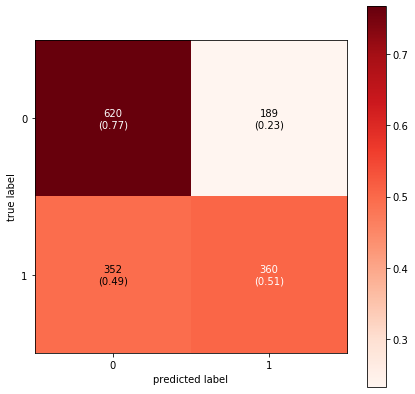

roc_auc score:  0.6953028430160693


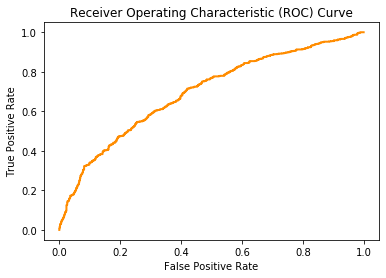

In [32]:
fun.hybrid_classifiers(X_train, X_test, y_train, y_test, LinearSVC())

### SVC

              precision    recall  f1-score   support

           0       0.64      0.77      0.70       809
           1       0.66      0.52      0.58       712

    accuracy                           0.65      1521
   macro avg       0.65      0.64      0.64      1521
weighted avg       0.65      0.65      0.64      1521



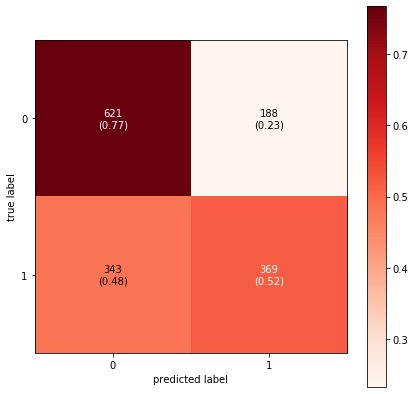

roc_auc score:  0.7089415424785767


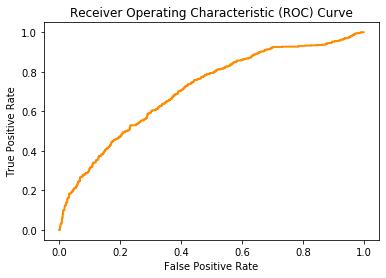

In [33]:
fun.hybrid_classifiers(X_train, X_test, y_train, y_test, SVC())

### Logistic Regression

              precision    recall  f1-score   support

           0       0.62      0.73      0.67       809
           1       0.62      0.49      0.55       712

    accuracy                           0.62      1521
   macro avg       0.62      0.61      0.61      1521
weighted avg       0.62      0.62      0.61      1521



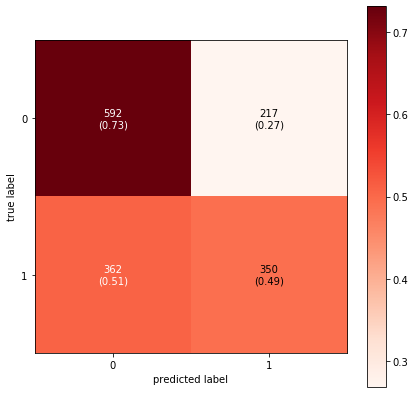

roc_auc score:  0.6676018388633491


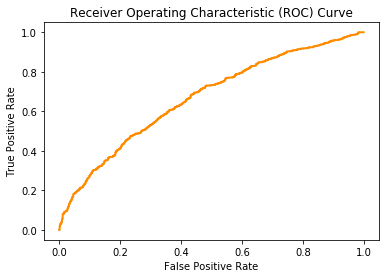

In [34]:
fun.hybrid_classifiers(X_train, X_test, y_train, y_test, LogisticRegression())

### Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.64      0.56      0.60       455
           1       0.53      0.61      0.57       374

    accuracy                           0.58       829
   macro avg       0.59      0.59      0.58       829
weighted avg       0.59      0.58      0.58       829



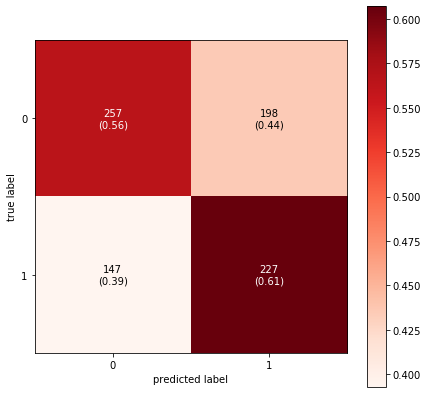

In [36]:
fun.script_classifiers(X_train, y_train, DecisionTreeClassifier())

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.62      0.78      0.69       809
           1       0.65      0.46      0.54       712

    accuracy                           0.63      1521
   macro avg       0.64      0.62      0.62      1521
weighted avg       0.64      0.63      0.62      1521



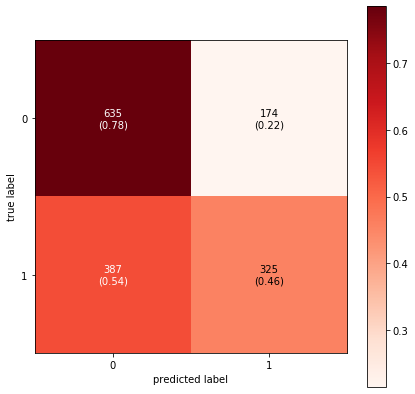

In [37]:
fun.hybrid_classifiers(X_train, X_test, y_train, y_test, RandomForestClassifier(
                                                max_depth=8,
                                                criterion='entropy',
                                                min_samples_split=14,
                                                min_samples_leaf=1,
                                                max_features=160))

### XGBoost Classifier

              precision    recall  f1-score   support

           0       0.65      0.80      0.72       809
           1       0.69      0.50      0.58       712

    accuracy                           0.66      1521
   macro avg       0.67      0.65      0.65      1521
weighted avg       0.67      0.66      0.66      1521



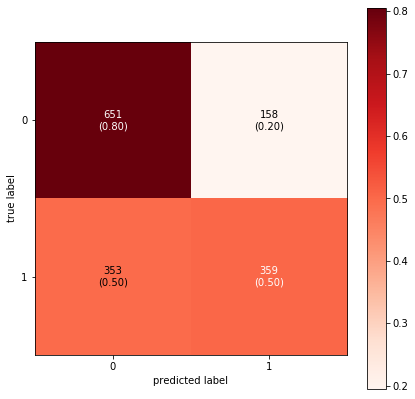

In [38]:
fun.hybrid_classifiers(X_train, X_test, y_train, y_test, 
                   XGBClassifier(max_depth=8,
                                    criterion='entropy',
                                    min_samples_split=14,
                                    min_samples_leaf=1,
                                    max_features=160))

### Multinomial Bayes

              precision    recall  f1-score   support

           0       0.58      0.75      0.65       809
           1       0.57      0.38      0.46       712

    accuracy                           0.58      1521
   macro avg       0.58      0.57      0.56      1521
weighted avg       0.58      0.58      0.56      1521



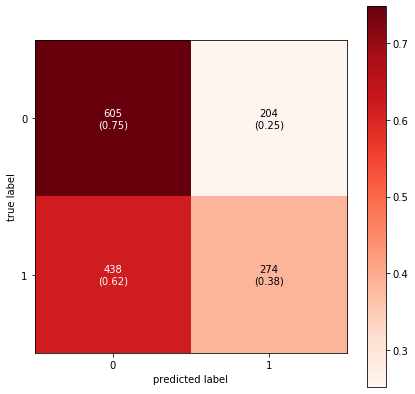

In [39]:
fun.hybrid_classifiers(X_train, X_test, y_train, y_test, MultinomialNB())

### Neural Network

In [42]:
X_train = screenplays_cut.no_stop
X_test = rotten_df_cut.NoStop

y_train = screenplays_cut.good_or_bad
y_test = rotten_df_cut.good_or_bad

# X = X.loc[~X.index.duplicated(keep='first')]
# y = y.loc[~y.index.duplicated(keep='first')]

In [43]:
X_train = pd.DataFrame(X_train)

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

X_resampled = X_resampled.iloc[:, 0]

In [44]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
X_t_train = tfidf.fit_transform(X_resampled)
X_t_test = tfidf.transform(X_test)

In [45]:
X_t_train = pd.SparseDataFrame(X_t_train, columns=tfidf.get_feature_names(),
                           default_fill_value=0)
X_t_test = pd.SparseDataFrame(X_t_test, columns=tfidf.get_feature_names(),
                           default_fill_value=0)

X_t_num = np.array(X_t_train)
X_t_test_num = np.array(X_t_test)

y_t_num = np.array(y_resampled)
y_t_test_num = np.array(y_test)

In [46]:
layer_input = X_t_train.shape[1]

In [47]:
model = Sequential()

model.add(Dense(layer_input, input_dim=layer_input, activation='relu'))
model.add(Dense(50, input_dim=layer_input, activation='relu'))
model.add(Dense(50, input_dim=50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [48]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

model.fit(X_t_num, y_t_num, epochs=4, batch_size=50, validation_split=0.2)

Train on 2006 samples, validate on 502 samples
Epoch 1/4
2006/2006 [==============================] - 6s 3ms/step - loss: 0.1994 - accuracy: 0.6939 - val_loss: 0.2756 - val_accuracy: 0.5837
Epoch 2/4
2006/2006 [==============================] - 6s 3ms/step - loss: 0.1098 - accuracy: 0.8485 - val_loss: 0.4755 - val_accuracy: 0.3645
Epoch 3/4
2006/2006 [==============================] - 6s 3ms/step - loss: 0.0755 - accuracy: 0.9048 - val_loss: 0.1787 - val_accuracy: 0.7570
Epoch 4/4
2006/2006 [==============================] - 7s 3ms/step - loss: 0.0319 - accuracy: 0.9671 - val_loss: 0.1613 - val_accuracy: 0.7928


In [49]:
# y_t_test = y_test

In [50]:
model.evaluate(X_t_test_num, y_t_test_num, verbose=1)

1521/1521 [==============================] - 1s 362us/step


[0.27694066365559894, 0.6482577323913574]

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       809
           1       0.64      0.55      0.60       712

    accuracy                           0.65      1521
   macro avg       0.65      0.64      0.64      1521
weighted avg       0.65      0.65      0.65      1521



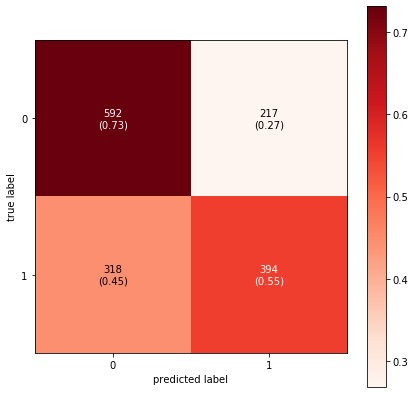

In [51]:
y_pred = model.predict_classes(X_t_test_num)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

## Script Attributes

### Setup

In [156]:
screen_dummies = pd.get_dummies(screenplays_model['category'])
rotten_dummies = pd.get_dummies(rotten_model['category'])

In [157]:
columns = ['.', 'CC', 'VERB', 'CCONJ', 'PRON', 'sentiment_neutral', 
           'sentiment_positive', 'sentiment_compound', 'colon_ratios'] 
# columns = ['unique_words', 'word_count', 'sentence_length', 
#                     'sentiment_negative', 'sentiment_neutral', 
#                     'sentiment_positive', 'sentiment_compound',
#                     'ellipsis_ratios', 'semi_ratios', 'colon_ratios', 
#                     'comma_ratios']


columns = list(screenplays_model.columns[5:7])
columns.extend(list(screenplays_model.columns[9:18]))
start = list(screenplays_model.columns).index('PROPN')
columns.extend(list(screenplays_model.columns[start:-1]))
    
X = screenplays_cut[columns]
X_train = pd.merge(screenplays_model[columns], screen_dummies, left_index=True, 
             right_index=True)
X_test = pd.merge(rotten_model[columns], rotten_dummies, left_index=True, 
             right_index=True)

# X_train = screen_dummies
# X_test = rotten_dummies

# X_train = screenplays_model[columns]
# X_test = rotten_model[columns]

y_train = screenplays_model.good_or_bad
y_test = rotten_model.good_or_bad

In [54]:
# X_train = X.loc[~X.index.duplicated(keep='first')]
# y_train = y.loc[~y.index.duplicated(keep='first')]

### Support Vector Classifier

              precision    recall  f1-score   support

           0       0.55      0.77      0.64       809
           1       0.53      0.30      0.38       712

    accuracy                           0.55      1521
   macro avg       0.54      0.53      0.51      1521
weighted avg       0.54      0.55      0.52      1521



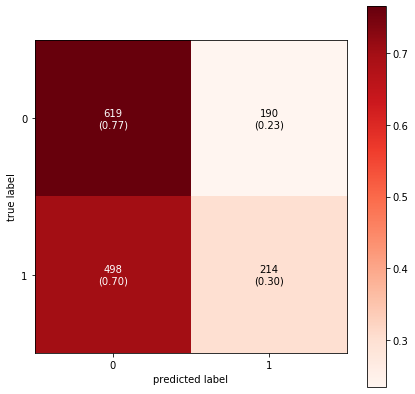

roc_auc score:  0.5507614477576701


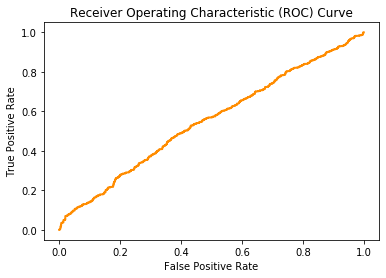

In [55]:
hybrid_classifiers(X_train, X_test, y_train, y_test, classifier=SVC(), 
                   use_tfidf=False)

### Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.55      0.51      0.53       809
           1       0.48      0.52      0.50       712

    accuracy                           0.51      1521
   macro avg       0.51      0.51      0.51      1521
weighted avg       0.52      0.51      0.51      1521



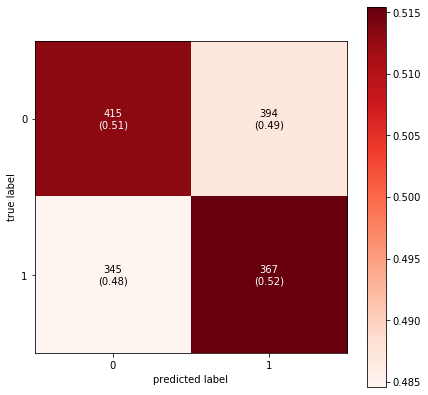

In [56]:
hybrid_classifiers(X_train, X_test, y_train, y_test, 
                   classifier=DecisionTreeClassifier(), use_tfidf=False)

### Logistic Regression Classifier

              precision    recall  f1-score   support

           0       0.59      0.40      0.48       809
           1       0.50      0.69      0.58       712

    accuracy                           0.53      1521
   macro avg       0.55      0.54      0.53      1521
weighted avg       0.55      0.53      0.52      1521



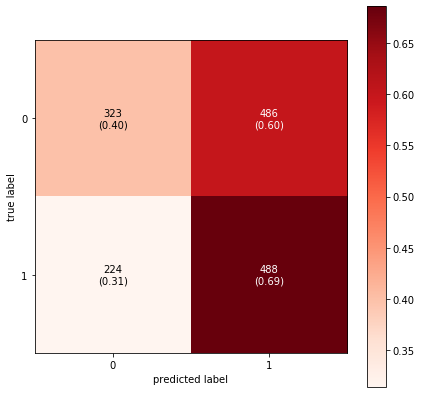

roc_auc score:  0.5642352189552923


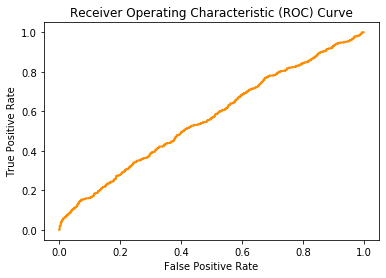

In [57]:
hybrid_classifiers(X_train, X_test, y_train, y_test, 
                   classifier=LogisticRegression(), use_tfidf=False)

### XG Boost Classifier

              precision    recall  f1-score   support

           0       0.65      0.20      0.31       809
           1       0.49      0.88      0.63       712

    accuracy                           0.52      1521
   macro avg       0.57      0.54      0.47      1521
weighted avg       0.58      0.52      0.46      1521



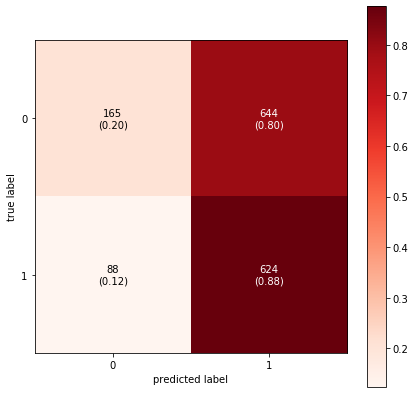

In [58]:
hybrid_classifiers(X_train, X_test, y_train, y_test, 
                   classifier=XGBClassifier(),use_tfidf=False)

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.60      0.38      0.47       809
           1       0.50      0.71      0.59       712

    accuracy                           0.54      1521
   macro avg       0.55      0.55      0.53      1521
weighted avg       0.56      0.54      0.53      1521



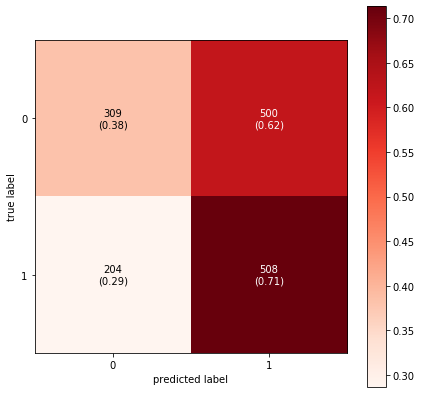

In [59]:
hybrid_classifiers(X_train, X_test, y_train, y_test, 
                   classifier=RandomForestClassifier(random_state=42,
                                                    max_depth=8,
                                                    criterion='entropy',
                                                    min_samples_split=14,
                                                    min_samples_leaf=1,
#                                                     max_features=10),
                                                    ),
                  use_tfidf=False)

### Neural Network

In [60]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
X_train = pd.DataFrame(X_train)

In [62]:
rus = RandomUnderSampler(random_state=42)
Xt_resampled, yt_resampled = rus.fit_resample(X_train, y_train)

In [63]:
# y_t_train = pd.get_dummies(yt_resampled)
X_t_train = np.array(Xt_resampled)
y_t_train = np.array(yt_resampled)

In [64]:
layer_input = X_t_train.shape[1]

In [65]:
model = Sequential()

model.add(Dense(64, input_dim=layer_input, activation='relu'))
model.add(Dense(32, input_dim=64, activation='relu'))
model.add(Dense(16, input_dim=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [66]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [67]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                5632      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 8,257
Trainable params: 8,257
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.fit(X_t_train, y_t_train, epochs=8, batch_size=50, validation_split=0.1)

Train on 2257 samples, validate on 251 samples
Epoch 1/8
2257/2257 [==============================] - 0s 87us/step - loss: 0.2265 - accuracy: 0.6420 - val_loss: 0.2978 - val_accuracy: 0.4223
Epoch 2/8
2257/2257 [==============================] - 0s 24us/step - loss: 0.1985 - accuracy: 0.6978 - val_loss: 0.2735 - val_accuracy: 0.5179
Epoch 3/8
2257/2257 [==============================] - 0s 29us/step - loss: 0.1825 - accuracy: 0.7359 - val_loss: 0.2823 - val_accuracy: 0.5378
Epoch 4/8
2257/2257 [==============================] - 0s 27us/step - loss: 0.1714 - accuracy: 0.7550 - val_loss: 0.2661 - val_accuracy: 0.5737
Epoch 5/8
2257/2257 [==============================] - 0s 26us/step - loss: 0.1624 - accuracy: 0.7705 - val_loss: 0.2607 - val_accuracy: 0.5896
Epoch 6/8
2257/2257 [==============================] - 0s 24us/step - loss: 0.1526 - accuracy: 0.7878 - val_loss: 0.2821 - val_accuracy: 0.5538
Epoch 7/8
2257/2257 [==============================] - 0s 25us/step - loss: 0.1448 - accu

In [69]:
X_t_test = X_test
y_t_test = y_test

In [70]:
model.evaluate(X_t_test, y_t_test, verbose=1)

1521/1521 [==============================] - 0s 17us/step


[0.5309114498775608, 0.46811309456825256]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       809
           1       0.47      1.00      0.64       712

    accuracy                           0.47      1521
   macro avg       0.23      0.50      0.32      1521
weighted avg       0.22      0.47      0.30      1521



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


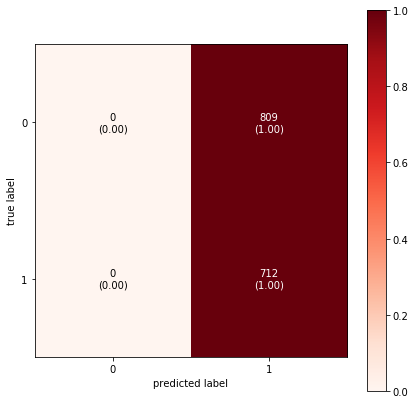

In [71]:
y_pred = model.predict_classes(X_t_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

## Combined TDIF & Attributes

### Setup

In [226]:
screenplays_model = screenplays_model.copy().drop(
    index=(screenplays_model[screenplays_model['word_count'] < 1000].index), axis=0)
rotten_model = rotten_model.copy().drop(
    index=(rotten_model[rotten_model['word_count'] < 1000].index), axis=0)

In [162]:
screen_dummies = pd.get_dummies(screenplays_model['category'])
rotten_dummies = pd.get_dummies(rotten_model['category'])

In [227]:
# columns = ['CC', 'VERB', 'CCONJ', 'PRON', 'sentiment_neutral', 
#            'sentiment_positive', 'sentiment_compound', 'colon_ratios']
columns = ['CCONJ']
# columns = ['unique_words', 'word_count', 'sentence_length', 
#                     'sentiment_negative', 'sentiment_neutral', 
#                     'sentiment_positive', 'sentiment_compound',
#                     'ellipsis_ratios', 'semi_ratios', 'colon_ratios', 
#                     'comma_ratios']

# for column in screenplays_model.columns[23:-1]:
#     columns.append(column)
    
# X = screenplays_cut[columns]
# X_train = pd.merge(screenplays_model[columns], screen_dummies, left_index=True, 
#              right_index=True)
# X_test = pd.merge(rotten_model[columns], rotten_dummies, left_index=True, 
#              right_index=True)

X_train = screenplays_model[columns].copy()
X_test = rotten_model[columns].copy()

# X = screenplays_cut[['unique_words', 'word_count']]
y_train = screenplays_model.good_or_bad.copy()
y_test = rotten_model.good_or_bad.copy()

In [229]:
X2_train = screenplays_model.no_stop
X2_test = rotten_model.NoStop
y_train = screenplays_model.good_or_bad
y_test = rotten_model.good_or_bad

In [230]:
# X_train = X_train.loc[~X_train.index.duplicated(keep='first')]
# y_train = y_train.loc[~y_train.index.duplicated(keep='first')]
# X_test = X_test.loc[~X_test.index.duplicated(keep='first')]
# y_test = y_test.loc[~y_test.index.duplicated(keep='first')]

### Linear Support Vector Classifier

In [274]:
# temp = pd.DataFrame(X2_train, columns=['temp'])
# temp[temp['temp'].isna() == True].index

Index([], dtype='object')

In [293]:
len(screenplays_model)

2763

In [304]:
# screenplays_model.iloc[[40, 69, 101, 106, 147, 175, 264, 303, 343, 371, 392,
#              464, 656, 811, 963, 1099, 2024, 2044, 2066, 2265, 2554, 2600]]

In [333]:
rotten_df_cut[42:50]

,Titles,TitlesFormatted,RottenScores,Scripts,AllTogetherNow,NoStop,JustWords,word_count,unique_words,sentiment_scores,sentiment_negative,sentiment_neutral,sentiment_positive,sentiment_compound,colon_ratios,semi_ratios,comma_ratios,ellipsis_ratios,sentence_length,category,CategoryLabel,nlp,POS_counts,TAG_counts,PROPN,PUNCT,SYM,VERB,X,SPACE,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,HYPH,``,XX,FW,WP,VBG,UH,RBS,-LRB-,NNP,VBZ,MD,NFP,:,VBP,-RRB-,ADD,DT,'',IN,AFX,.,TO,CC,VBN,NN,",",EX,JJR,PRP$,POS,LS,WRB,JJ,RP,CD,PRP,RB,NNPS,VB,PDT,RBR,WDT,JJS,VBD,_SP,WP$,NNS,$,good_or_bad
42,getting_even_with_dad,getting-even-with-dad,2,"[""\n\n (MONEY THAT'S WH...","[""\n\n (MONEY THAT'S WH...","[""\n\n (money that's wan playing)"", ' best th...",nn money thats wan playing best things life f...,16100,11069,"{'neg': 0.048, 'neu': 0.787, 'pos': 0.166, 'co...",0.048,0.787,0.166,1.0000,0.009847,0.0,0.433192,0.006053,12.708381,1,Action & Science Fiction,"[""\n\n (MONEY THAT'S WH...","{97: 14340, 93: 156, 103: 2, 92: 1710, 90: 128...","{17111077179131903759: 125, 496985742939665190...",0.042795,0.890683,0.000000,0.210683,0.000000,0.000124,0.035466,0.050000,0.074969,0.006770,0.013851,0.079938,0.035031,0.106211,0.009689,0.028944,0.141118,0.002050,0.065404,0.000000,0.000000,0.014348,0.018882,0.035031,0.000186,0.007764,0.042609,0.030497,0.015528,0.001863,0.008323,0.050932,0.007764,0.000000,0.068323,0.372733,0.050000,0.0,0.126957,0.014037,0.013851,0.007516,0.085404,0.297826,0.000932,0.000932,0.010062,0.003727,0.000000,0.007578,0.033913,0.011180,0.009689,0.126770,0.065776,0.000186,0.071801,0.000870,0.000497,0.000683,0.000621,0.022298,0.000124,0.000000,0.020807,0.000497,0
44,passion_play,passion-play,2,"['\n\n Hey, Billy.', "" ...","['\n\n Hey, Billy.', "" ...","['\n\n hey, billy.', "" it's thursday."", ' com...",nn hey billy thursday come tomorrow actually ...,5411,3772,"{'neg': 0.089, 'neu': 0.757, 'pos': 0.154, 'co...",0.089,0.757,0.154,0.9994,0.000000,0.0,0.423118,0.020414,12.407895,2,Dark Movies and Documentaries,"['\n\n Hey, Billy.', "" ...","{97: 4942, 93: 24, 103: 2, 91: 240, 96: 162, 9...","{17111077179131903759: 1, 4969857429396651903:...",0.029939,0.913325,0.000000,0.208649,0.000370,0.000370,0.036038,0.050083,0.076696,0.007577,0.013861,0.081316,0.044354,0.105526,0.004435,0.031417,0.142857,0.001294,0.070967,0.000185,0.000185,0.009425,0.014045,0.044354,0.000000,0.000185,0.029015,0.025319,0.017557,0.004805,0.007947,0.058030,0.000185,0.000000,0.062096,0.384402,0.050083,0.0,0.148586,0.014600,0.013861,0.006838,0.089078,0.294955,0.000924,0.000000,0.016448,0.004990,0.000000,0.006283,0.035668,0.011828,0.004435,0.133432,0.069303,0.000924,0.074478,0.001294,0.000185,0.001294,0.000370,0.019959,0.000370,0.000185,0.016448,0.000000,0
45,half_past_dead,half-past-dead,2,"['\n\n So, Nick...', ' ...","['\n\n So, Nick...', ' ...","['\n\n so, nick...', ' ...this it?', ' promis...",nn nick promised lets plane catch know sonny ...,7339,4888,"{'neg': 0.111, 'neu': 0.762, 'pos': 0.127, 'co...",0.111,0.762,0.127,0.9905,0.000409,0.0,0.321195,0.019435,9.491262,0,Classical & British,"['\n\n So, Nick...', ' ...","{97: 5697, 93: 120, 103: 2, 86: 471, 96: 313, ...","{17111077179131903759: 1, 4969857429396651903:...",0.042649,0.776264,0.000000,0.202207,0.000273,0.000273,0.044693,0.057910,0.064178,0.005178,0.013898,0.094018,0.011037,0.123859,0.016351,0.027933,0.133533,0.002998,0.041968,0.000136,0.000136,0.014035,0.019485,0.011037,0.000136,0.000136,0.041968,0.024527,0.010492,0.002044,0.053004,0.050279,0.000136,0.000000,0.067720,0.307399,0.057910,0.0,0.154653,0.012536,0.013898,0.010901,0.101240,0.213926,0.001499,0.001635,0.024390,0.002998,0.000000,0.007358,0.042376,0.012400,0.016351,0.119499,0.054095,0.000681,0.064178,0.000954,0.001090,0.000954,0.000681,0.027524,0.000273,0.000000,0.022619,0.000273,0
46,feardotcom,feardotcom,2,"['\n\n No!', ' Damn.', ...","['\n\n No!', ' Damn.', ...","['\n\n no!', ' damn.', ' thanks present, benn...",nn damn thanks present bennie guess business .

In [328]:
rotten_model.iloc[42:50]

,TitlesFormatted,Scripts,AllTogetherNow,NoStop,JustWords,word_count,unique_words,sentiment_scores,sentiment_negative,sentiment_neutral,sentiment_positive,sentiment_compound,colon_ratios,semi_ratios,comma_ratios,ellipsis_ratios,sentence_length,category,CategoryLabel,nlp,POS_counts,TAG_counts,PROPN,PUNCT,SYM,VERB,X,SPACE,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,$,'',",",-LRB-,-RRB-,.,:,ADD,AFX,CC,CD,DT,EX,FW,HYPH,IN,JJ,JJR,JJS,LS,MD,NFP,NN,NNP,NNPS,NNS,PDT,POS,PRON,PRP,PRP$,RB,RBR,RBS,RP,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,XX,_SP,``,good_or_bad,RottenScores
42,getting-even-with-dad,"[""\n\n (MONEY THAT'S WH...","[""\n\n (MONEY THAT'S WH...","[""\n\n (money that's wan playing)"", ' best th...",nn money thats wan playing best things life f...,16100,11069,"{'neg': 0.048, 'neu': 0.787, 'pos': 0.166, 'co...",0.048,0.787,0.166,1.0000,0.009847,0.0,0.433192,0.006053,12.708381,1,Action & Science Fiction,"[""\n\n (MONEY THAT'S WH...","{97: 14340, 93: 156, 103: 2, 92: 1710, 90: 128...","{17111077179131903759: 125, 496985742939665190...",0.042795,0.890683,0.000000,0.210683,0.000000,0.000124,0.035466,0.050000,0.074969,0.006770,0.013851,0.079938,0.035031,0.106211,0.009689,0.028944,0.000497,0.372733,0.297826,0.007764,0.007764,0.126957,0.008323,0.000000,0.0,0.013851,0.009689,0.068323,0.000932,0.000000,0.002050,0.050000,0.033913,0.000932,0.000621,0.000000,0.015528,0.001863,0.085404,0.042609,0.000186,0.020807,0.000870,0.003727,0.141118,0.126770,0.010062,0.065776,0.000497,0.000186,0.011180,0.014037,0.035031,0.071801,0.022298,0.018882,0.007516,0.050932,0.030497,0.000683,0.014348,0.000000,0.007578,0.000000,0.000124,0.065404,0,2
44,passion-play,"['\n\n Hey, Billy.', "" ...","['\n\n Hey, Billy.', "" ...","['\n\n hey, billy.', "" it's thursday."", ' com...",nn hey billy thursday come tomorrow actually ...,5411,3772,"{'neg': 0.089, 'neu': 0.757, 'pos': 0.154, 'co...",0.089,0.757,0.154,0.9994,0.000000,0.0,0.423118,0.020414,12.407895,2,Dark Movies and Documentaries,"['\n\n Hey, Billy.', "" ...","{97: 4942, 93: 24, 103: 2, 91: 240, 96: 162, 9...","{17111077179131903759: 1, 4969857429396651903:...",0.029939,0.913325,0.000000,0.208649,0.000370,0.000370,0.036038,0.050083,0.076696,0.007577,0.013861,0.081316,0.044354,0.105526,0.004435,0.031417,0.000000,0.384402,0.294955,0.000185,0.000185,0.148586,0.007947,0.000000,0.0,0.013861,0.004435,0.062096,0.000924,0.000185,0.001294,0.050083,0.035668,0.000000,0.000370,0.000000,0.017557,0.004805,0.089078,0.029015,0.000924,0.016448,0.001294,0.004990,0.142857,0.133432,0.016448,0.069303,0.000185,0.000000,0.011828,0.014600,0.044354,0.074478,0.019959,0.014045,0.006838,0.058030,0.025319,0.001294,0.009425,0.000185,0.006283,0.000185,0.000370,0.070967,0,2
45,half-past-dead,"['\n\n So, Nick...', ' ...","['\n\n So, Nick...', ' ...","['\n\n so, nick...', ' ...this it?', ' promis...",nn nick promised lets plane catch know sonny ...,7339,4888,"{'neg': 0.111, 'neu': 0.762, 'pos': 0.127, 'co...",0.111,0.762,0.127,0.9905,0.000409,0.0,0.321195,0.019435,9.491262,0,Classical & British,"['\n\n So, Nick...', ' ...","{97: 5697, 93: 120, 103: 2, 86: 471, 96: 313, ...","{17111077179131903759: 1, 4969857429396651903:...",0.042649,0.776264,0.000000,0.202207,0.000273,0.000273,0.044693,0.057910,0.064178,0.005178,0.013898,0.094018,0.011037,0.123859,0.016351,0.027933,0.000273,0.307399,0.213926,0.000136,0.000136,0.154653,0.053004,0.000000,0.0,0.013898,0.016351,0.067720,0.001499,0.000136,0.002998,0.057910,0.042376,0.001635,0.000681,0.000000,0.010492,0.002044,0.101240,0.041968,0.000681,0.022619,0.000954,0.002998,0.133533,0.119499,0.024390,0.054095,0.001090,0.000136,0.012400,0.012536,0.011037,0.064178,0.027524,0.019485,0.010901,0.050279,0.024527,0.000954,0.014035,0.000000,0.007358,0.000136,0.000273,0.041968,0,2
46,feardotcom,"['\n\n No!', ' Damn.', ...","['\n\n No!', ' Damn.', ...","['\n\n no!', ' damn.', ' thanks present, benn...",nn damn thanks present bennie guess business ...,4414,2871,"{'neg': 0.161, 'neu': 0.722, 'pos': 0.116, 'co...",0.161

In [327]:
X_test.iloc[42:50]

,CCONJ
42,0.013851
44,0.013861
45,0.013898
46,0.009742
48,0.015599
49,0.014819
50,0.013170
53,0.010985


In [325]:
hybrid_classifier_combo(X_train, X_test, X2_train, X2_test,
                        y_train, y_test, LinearSVC(C=.6))

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43       True
44      False
45      False
46      False
47       True
48      False
49      False
50      False
51       True
52       True
53      False
54       True
55      False
56       True
57      False
58       True
59      False
60      False
61      False
62       True
63       True
64      False
65      False
66      False
67      False
68      False
69      False
70      False
71    

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Support Vector Classifier

In [ ]:
hybrid_classifier_combo(X_train, X_test, X2_train, X2_test,
                        y_train, y_test, SVC(C=.1), feature_importance=False)

### Decision Tree Classifier

In [ ]:
hybrid_classifier_combo(X_train, X_test, X2_train, X2_test,
                        y_train, y_test, DecisionTreeClassifier())

### Logistic Regression Classifier

In [ ]:
hybrid_classifier_combo(X_train, X_test, X2_train, X2_test,
                        y_train, y_test, LogisticRegression(C=10))

### XG Boost Classifier

In [ ]:
# hybrid_classifier_combo(X_train, X_test, X2_train, X2_test,
#                         y_train, y_test, XGBClassifier())
# XG Boost did not like the sparse dataframe for some reason. Skipping.

### Random Forest Classifier

In [ ]:
hybrid_classifier_combo(X_train, X_test, X2_train, X2_test,
                        y_train, y_test, 
                        RandomForestClassifier(random_state=42, 
                                               n_jobs=-1),
                        feature_importance=False)

### Neural Network

Couldn't seem to get this model to work, though I tried plenty of different things. For a minute there, I had a model with an accuracy of .6 or so, but that was about the best I could do and it all went downhillf rom there.

In [ ]:
screen_dummies = pd.get_dummies(screenplays_model['category'])
rotten_dummies = pd.get_dummies(rotten_model['category'])

In [ ]:
columns = ['.', 'CC', 'VERB', 'CCONJ', 'PRON', 'sentiment_neutral', 
           'sentiment_positive', 'sentiment_compound', 'colon_ratios']
# columns = ['unique_words', 'word_count', 'sentence_length', 
#                     'sentiment_negative', 'sentiment_neutral', 
#                     'sentiment_positive', 'sentiment_compound',
#                     'ellipsis_ratios', 'semi_ratios', 'colon_ratios', 
#                     'comma_ratios']

# for column in screenplays_model.columns[23:-1]:
#     columns.append(column)
    
# X = screenplays_cut[columns]
# X_train = pd.merge(screenplays_model[columns], screen_dummies, left_index=True, 
#              right_index=True)
# X_test = pd.merge(rotten_model[columns], rotten_dummies, left_index=True, 
#              right_index=True)

X_train = screenplays_model[columns]
X_test = rotten_model[columns]

y_train = screenplays_model.good_or_bad
y_test = rotten_model.good_or_bad

In [ ]:
X2_train = screenplays_model.no_stop
X2_test = rotten_model.no_stop
y_train = screenplays_model.good_or_bad
y_test = rotten_model.good_or_bad

In [ ]:
tfidf = TfidfVectorizer(max_features=100, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
X2_t_train = tfidf.fit_transform(X2_train)
X2_t_test = tfidf.transform(X2_test)

In [ ]:
X_sdf1 = pd.SparseDataFrame(X2_t_train, columns=tfidf.get_feature_names(),
                           default_fill_value=0)
X_sdf2 = pd.SparseDataFrame(X2_t_test, columns=tfidf.get_feature_names(),
                           default_fill_value=0)

for column in X_train:
    X_sdf1[column] = X_train[column]
    X_sdf2[column] = X_test[column]

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_sdf1), y_train)

In [ ]:
# X_shuffled = shuffle(X_resampled, random_state=42)
# y_shuffled = shuffle(y_resampled, random_state=42)

In [ ]:
# X_t_train = pd.SparseDataFrame(X_resampled, columns=tfidf.get_feature_names(),
#                            default_fill_value=0)
# X_t_test = pd.SparseDataFrame(X_sdf2, columns=tfidf.get_feature_names(),
#                            default_fill_value=0)

# X_t_num = np.array(X_t_train)
# X_t_test_num = np.array(X_t_test)

# y_t_num = np.array(y_resampled)
# y_t_test_num = np.array(y_test)

In [ ]:
layer_input = X_sdf1.shape[1]

In [ ]:
model = Sequential()

model.add(Dense(layer_input, input_dim=layer_input, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='tanh'))

In [ ]:
model.compile(loss='squared_hinge',
              optimizer='sgd', 
              metrics=['accuracy'])

In [ ]:
model.fit(X_resampled, y_resampled, epochs=15, batch_size=30, 
          validation_split=0.1)

In [ ]:
# X_test_shuffled = shuffle(X_sdf2, random_state=42)
# y_test_shuffled = shuffle(y_test, random_state=42)

In [ ]:
model.metrics_names

In [ ]:
model.evaluate(pd.DataFrame(X_sdf2), y_test, verbose=1)

In [ ]:
y_pred = model.predict_classes(pd.DataFrame(X_sdf2))

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();